In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import itertools
import os
import imageio
from io import BytesIO
import random
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import pickle
from tqdm import tqdm
from scipy import stats
from multiprocessing import Pool

from graph_generation import GenerateGraph
from models import GCN, view_parameters, new_parameters, modify_parameters, Inits
from train import Trainer, Dataset
from embedding import Embedding
import experiments
from experiments import (Experiments, experiment_node_embedding, all_seeds)
from plot_funcs import (plot_dim1, plot_dimN, plot_correlation_error, plot_metrics, plot_node_emb_1D_perclass, scatter_node_emb, 
                        plot_graph_emb_1D, plot_data_degree_sequence, plot_corr_epoch, plot_ripetizioni_stesso_trial, 
                        plot_onlyloss_ripetizioni_stesso_trial_xp,
                        plot_onlyloss_ripetizioni_stesso_trial,
                        plot_onlyloss_ripetizioni_stesso_trial_superimposed)
from utils import array_wo_outliers, plot_grafo, plot_grafo2
from Inspect import Inspect
from config_valid import Config, TrainingMode
from GridConfigurations import GridConfigurations, open_df_results

import torch
from torch_geometric import nn
from torch_geometric.loader import DataLoader
import tensorflow as tf

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
from plt_parameters import init_params
init_params()
#pd.set_option('display.height', 500)

In [7]:
from time import time
import psutil
import tracemalloc
psutil.virtual_memory()#.percent

import resource
resource.getrusage(resource.RUSAGE_SELF).ru_maxrss
from time import sleep, time
from concurrent.futures import ThreadPoolExecutor

In [2]:
all_seeds()

In [2]:
rootsave = Path("output_plots/")
config_file = "configurations/classification_cm_manyclasses.yml"

# No training, Embedding a 0 epoche

In [3]:
diz_trials = {'graph_dataset.Num_nodes': [[500]*3, [500]*20, [500]*25, [500]*30],
             #'model.neurons_last_linear': [[20,20], [25,25], [30,30]],
             'graph_dataset.list_exponents': [list(np.round(np.linspace(-3.5, -6.5, 3),2)),
                                              list(np.round(np.linspace(-1.5, -4.5, 20),2)),
                                              list(np.round(np.linspace(-1.5, -4.5, 25),2)),
                                              list(np.round(np.linspace(-1.5, -4.5, 30),2))
                                            ],
             'model.neurons_last_linear':[ [10,10,3], [10, 10, 20], [10, 10, 25], [10, 10, 30] ]}

In [21]:
diz_trials = {'graph_dataset.Num_nodes': [[500] * 3, [500] * 5],
              'graph_dataset.list_exponents': [np.round(list(np.linspace(-3.5, -6.5, 3),2)),
                                               np.round(list(np.linspace(-1.5, -4.5, 5),2)),
                                               ],
              'model.neurons_last_linear': [[10, 10, 3], [10, 10, 5]]}


In [4]:
xp = Experiments(config_file, diz_trials, rootsave)

In [5]:
xp.diverse_classi_stesso_dataset()

60 configurazioni saltate su 64, farò 4 training


/home/daniele/Documenti/Progetti/Networks/Embednet/GridConfigurations.py:71: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df_cum = df_cum.reset_index().drop(columns=['index'])


Run 1
Generating dataset...
Dataset generated
Loading Dataset...


100%|█████████████████████████████████████████| 300/300 [00:05<00:00, 59.49it/s]


Tempo impiegato: 5.068853139877319
calcolo i risultati di interesse
Run 2
Generating dataset...
Dataset generated
Loading Dataset...


100%|███████████████████████████████████████| 2000/2000 [00:52<00:00, 37.78it/s]


Tempo impiegato: 53.13452363014221
calcolo i risultati di interesse
Run 3
Generating dataset...
Dataset generated
Loading Dataset...


100%|███████████████████████████████████████| 2500/2500 [01:05<00:00, 37.90it/s]


Tempo impiegato: 66.24038863182068
calcolo i risultati di interesse
Run 4
Generating dataset...
Dataset generated
Loading Dataset...


100%|███████████████████████████████████████| 3000/3000 [01:18<00:00, 38.09it/s]


Tempo impiegato: 79.06989789009094
calcolo i risultati di interesse


 devo salvare il dataframe che contiene oggetti non come un csv
 original_df.to_pickle("./dummy.pkl")

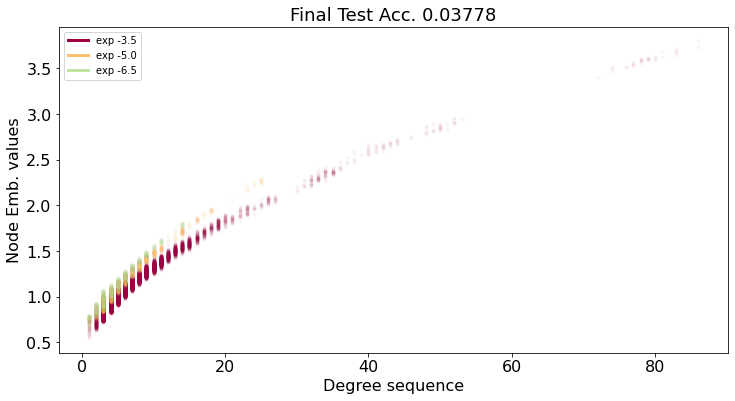

/home/daniele/anaconda3/envs/pytorch-geom/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


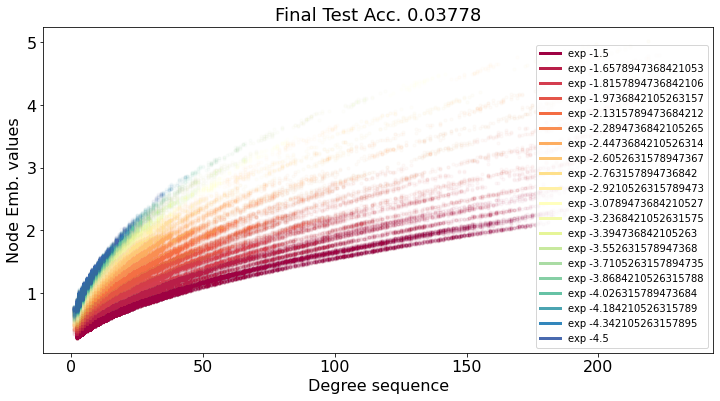

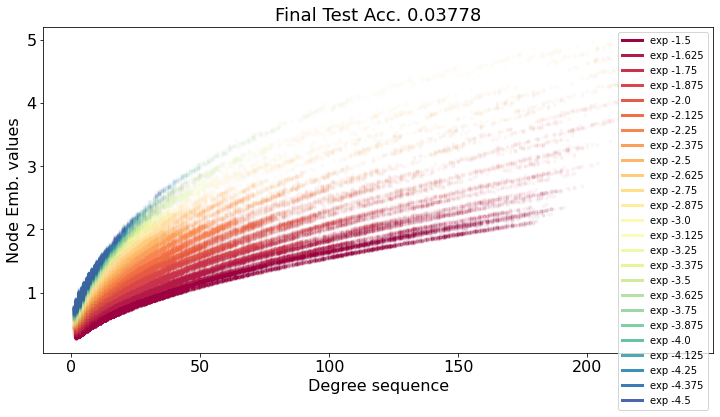

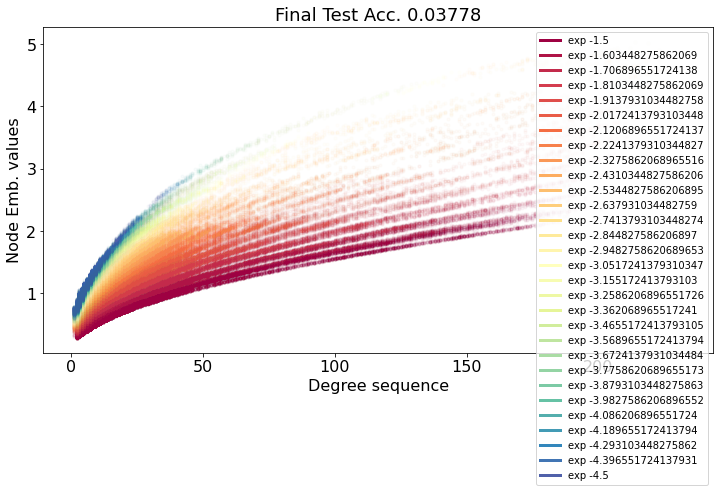

In [6]:
node_embs = xp.gc.config_dataframe[('risultati', 'node_embedding_class')]
for embs_by_class in node_embs:
    scatter_node_emb(embs_by_class.node_emb_perclass, xp.trainer.config_class, sequential_colors=True, filename=None)
    

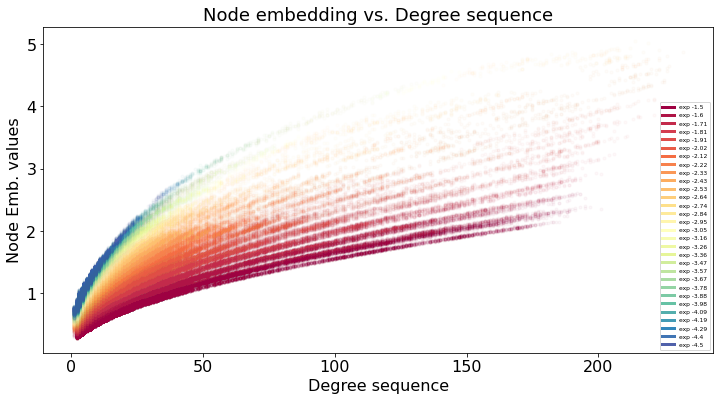

In [8]:
fname = xp.rootsave/Path("many_classes/scatter_30classes.png")
scatter_node_emb(node_embs[3].node_emb_perclass, xp.trainer.config_class, sequential_colors=True, filename=fname)

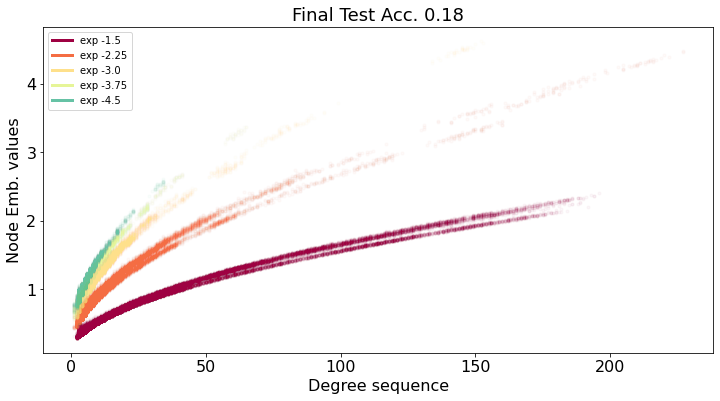

### 10 grafi per classe

In [20]:
# cambio il config con 10 grafi per classe
c = Config(config_file)
num_classi = 30
c.conf['graph_dataset']['Num_grafi_per_tipo'] = 10
c.conf['graph_dataset']['list_exponents'] = list(np.linspace(-1.5, -4.5, num_classi))
c.conf['graph_dataset']['Num_nodes'] = [100]*num_classi
c.conf['model']['neurons_last_linear'] = [10, 10, num_classi]
xp = Experiments(config_file, diz_trials=None, rootsave=rootsave, config_class=c)
xp.just_train()
node_embedding_class = xp.embedding()

Generating dataset...
Dataset generated
Loading Dataset...


100%|█████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 294.98it/s]


Tempo impiegato: 1.0515074729919434


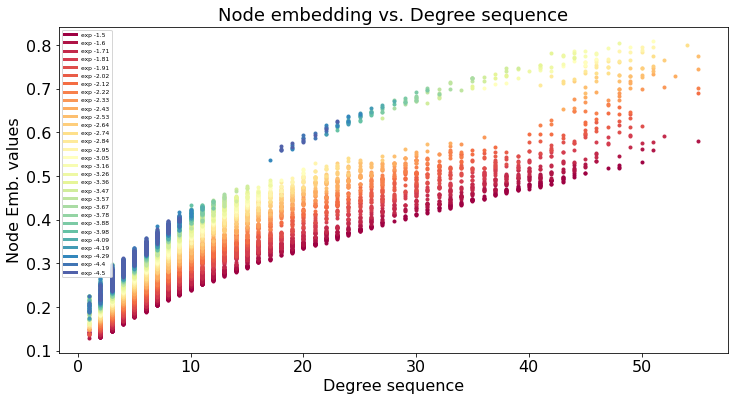

In [21]:
fname = xp.rootsave/Path("many_classes/scatter_30classes_10perclass_100nodes.png")
scatter_node_emb(node_embedding_class.node_emb_perclass, xp.trainer.config_class, sequential_colors=True, filename=fname)

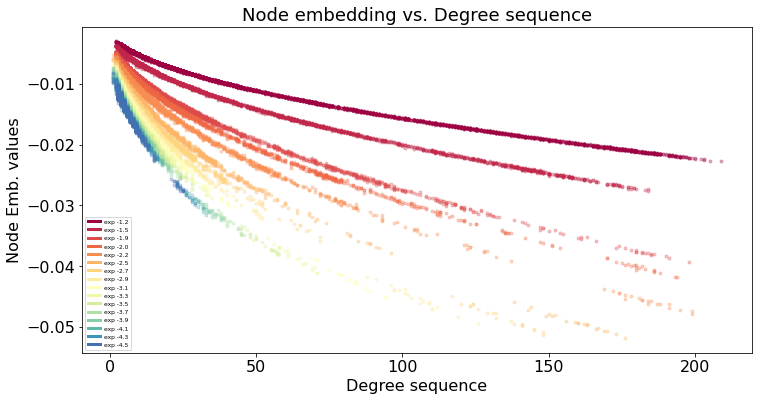

# Training dei layer Linear

In [3]:
c = Config(config_file)
c.conf['training']['epochs'] = 500
num_classi = 30
c.conf['graph_dataset']['Num_grafi_per_tipo'] = 100
c.conf['graph_dataset']['list_exponents'] = list(np.round(np.linspace(-1.5, -4.5, 30),2))
c.conf['graph_dataset']['Num_nodes'] = [500]*num_classi
c.conf['model']['neurons_last_linear'] = [10, 10, num_classi]
c.conf['model']['freezeGCNlayers'] = False

xp = Experiments(config_file, diz_trials=None, rootsave=rootsave, config_class=c)
xp.just_train()
node_embedding_class = xp.embedding()

Generating dataset...
Dataset generated
Loading Dataset...


100%|█████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:22<00:00, 36.22it/s]


Tempo impiegato: 83.1557104587555


100%|███████████████████████████████████████████████████████████████████████████████████████████| 500/500 [13:09<00:00,  1.58s/it]


test accuracy finale: 0.6722222222222223


In [10]:
#globals
experiments.graph_embedding_per_epoch = xp.trainer.graph_embedding_per_epoch
experiments.node_embedding_per_epoch = xp.trainer.node_embedding_per_epoch
experiments.dataset = xp.trainer.dataset
experiments.loss_list = xp.trainer.test_loss_list
experiments.exp_config = xp.trainer.config_class
avg_corr_classes, avg_tau_classes = xp.get_corrs_training(parallel=True)

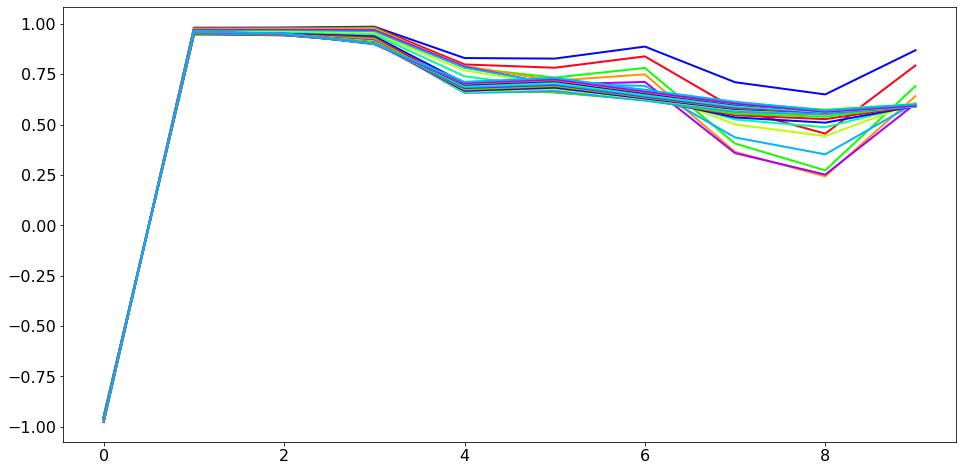

In [11]:
correlazioni = np.array(avg_corr_classes).T
for corr in correlazioni:
    plt.plot(corr)

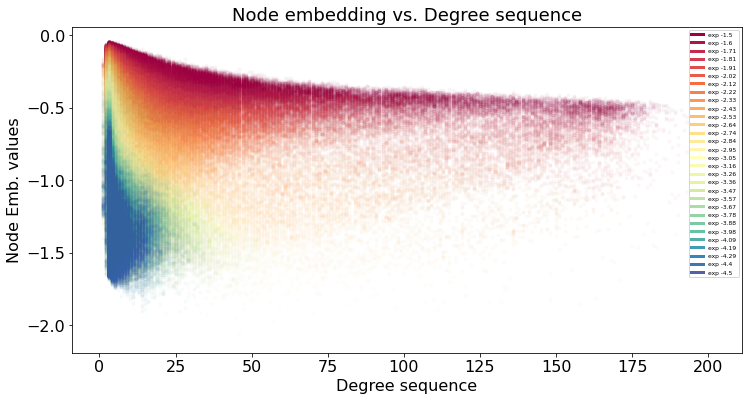

In [5]:
fname = xp.rootsave/Path("many_classes/scatter_30classes_trainable.png")
scatter_node_emb(node_embedding_class.node_emb_perclass, xp.trainer.config_class, sequential_colors=True, filename=fname)

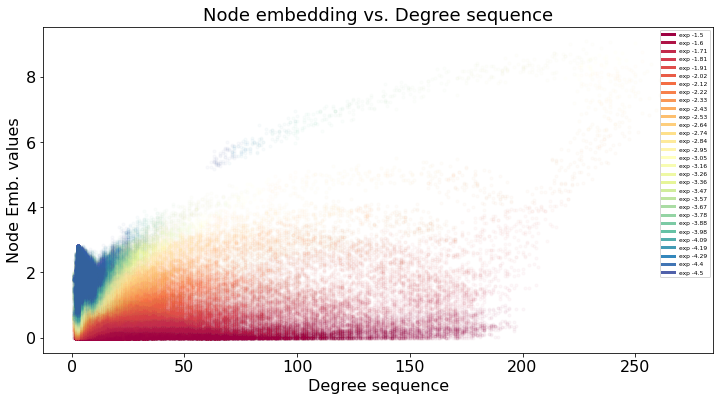

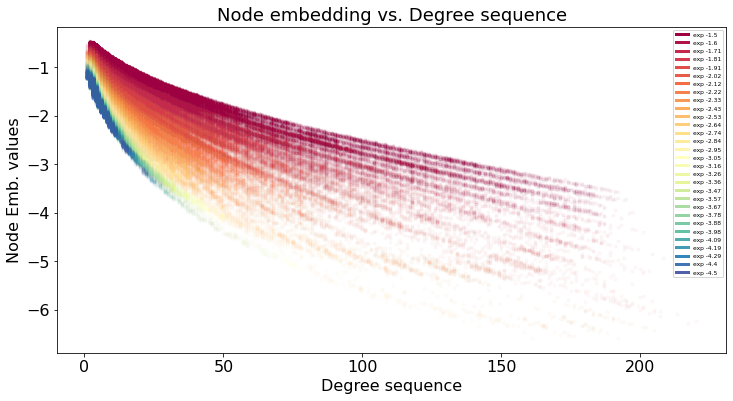

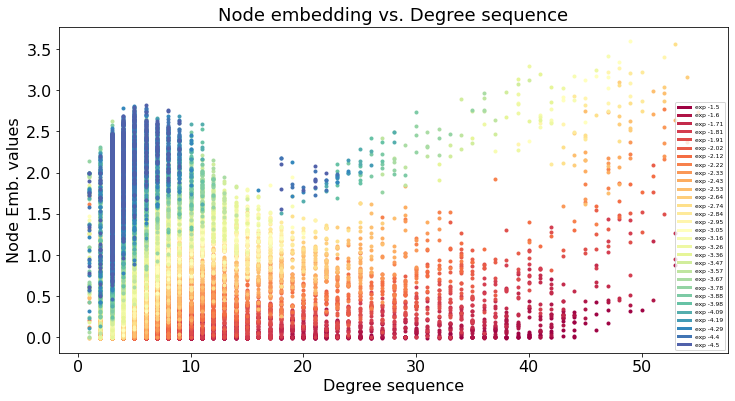

## recupero i dati salvati per rifare il plot animato

In [23]:
np.save('graph_emb.npy', xp.trainer.graph_embedding_per_epoch)

In [3]:
graph_embedding_per_epoch = np.load('graph_emb.npy')

In [24]:
np.save('node_emb.npy', xp.trainer.node_embedding_per_epoch)

In [4]:
node_embedding_per_epoch = np.load('node_emb.npy')

In [25]:
with open('dataset.pkl', 'wb') as file:
    pickle.dump(xp.trainer.dataset, file, protocol=pickle.HIGHEST_PROTOCOL)

In [5]:
with open('dataset.pkl', 'rb') as handle:
    dataset = pickle.load(handle)

In [26]:
np.save('test_loss_list.npy', xp.trainer.test_loss_list)

In [6]:
test_loss_list = np.load('test_loss_list.npy')

In [27]:
with open('configclass.pkl', 'wb') as file:
    pickle.dump(xp.trainer.config_class, file, protocol=pickle.HIGHEST_PROTOCOL)

In [7]:
with open('configclass.pkl', 'rb') as handle:
    configclass = pickle.load(handle)

In [28]:
np.save('output_per_epoch.npy', xp.trainer.output_per_epoch)

In [8]:
output_per_epoch = np.load('output_per_epoch.npy')

In [30]:
np.save('accuracy_list.npy', xp.trainer.accuracy_list)

In [9]:
accuracy_list = np.load('accuracy_list.npy')

In [32]:
xp.trainer.last_epoch

499

In [10]:
last_epoch = 499

In [18]:
#globals
experiments.graph_embedding_per_epoch = graph_embedding_per_epoch
experiments.node_embedding_per_epoch = node_embedding_per_epoch
experiments.dataset = dataset
experiments.loss_list = test_loss_list
experiments.exp_config = configclass


In [14]:
my_log_lista=list(range(20)) + list(range(20,50,2)) + list(range(50,250, 5)) + list(range(250, 500, 10))
len(my_log_lista)

100

In [15]:
def make_video(skip, fromfiles=True, isgif=False, both=True):

    if both:
        isgif = True
        isvideo = True
        fromfiles = True
    lista = my_log_lista  # range(0, last_epoch, skip)  no la creo io custom in stile simil logaritmico
    if fromfiles:
        parallel_save_many_images_embedding(lista)
        files = [f"scatter_epoch{i}.png" for i in lista]
    else:
        pictures = parallel_many_images_embedding(lista)

    numnodi = configclass.conf['graph_dataset']['Num_nodes']
    if isinstance(numnodi, list):
        numnodi = numnodi[0]
    numgrafi = configclass.conf['graph_dataset']['Num_grafi_per_tipo'] * 2
    exps = configclass.conf['graph_dataset']['list_exponents']
    if isinstance(exps, list):
        exps = f"{len(exps)}"
    percentuale_train = configclass.conf['training']['percentage_train']
    layers = configclass.conf['model']['GCNneurons_per_layer']
    denso = configclass.conf['model']['last_layer_dense']
    modo = configclass.conf['training']['mode']
    freezed = configclass.conf['model']['freezeGCNlayers']
    nomefile = f"scatter_exp{exps}_nodi{numnodi}_grafi{numgrafi}_percent{percentuale_train}_{modo}_layers{layers}_finaldense{denso}_freezed{freezed}"
    nomefile = nomefile.replace(', ', '_')
    print(nomefile)

    if isgif:
        if fromfiles:
            # files = [f"scatter_epoch{i}.png" for i in lista]
            ims = [imageio.imread(f) for f in files]
            imageio.mimwrite(nomefile + ".gif", ims, duration=0.1)
        else:
            ims = [imageio.imread(f) for f in pictures]
            imageio.mimwrite(nomefile, ims, duration=0.1)
    if isvideo:  # con ffmpeg per forza da file...o no?
        radice = "scatter_epoch"
        save_ffmpeg(radice, nomefile)

    if fromfiles:
        for f in files:
            os.remove(f)

    return nomefile

def parallel_save_many_images_embedding(lista):
        with Pool(processes=12) as pool:
            pool.map(mylambda_save, lista)
        return
    
def mylambda_save(i):
    mylambda_figure(i)
    plt.savefig(f"scatter_epoch{i}")
    plt.close()
    return

def mylambda_figure(i):
    graph_embeddings_array = graph_embedding_per_epoch[i]
    node_embeddings_array = node_embedding_per_epoch[i]
    node_embedding_class = NodeEmbedding(node_embeddings_array, [], dataset, test_loss_list, configclass)
    node_embedding_class.get_emb_per_graph(graph_embeddings_array)  # riempie node_emb_pergraph
    node_embedding_class.separate_embedding_by_classes()

    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    scatter_node_emb(node_embedding_class.node_emb_perclass, configclass, ax=axes[0][0], show=False, sequential_colors=True)
    plot_graph_emb_1D(node_embedding_class.node_emb_perclass, configclass, ax=axes[0][1], show=False, sequential_colors=True)
    axes[0][2].hist(np.array(output_per_epoch[i]).flatten(), bins=50);
    axes[1][0].plot(test_loss_list)
    axes[1][0].plot(i, test_loss_list[i], 'ro')
    axes[1][1].plot(accuracy_list)
    axes[1][1].plot(i, accuracy_list[i], 'ro')
    fig.suptitle(f"Network dynamics")
    return fig

In [20]:
lista = my_log_lista
files = [f"scatter_epoch{i}.png" for i in lista]
numnodi = configclass.conf['graph_dataset']['Num_nodes']
if isinstance(numnodi, list):
    numnodi = numnodi[0]
numgrafi = configclass.conf['graph_dataset']['Num_grafi_per_tipo'] * 2
exps = configclass.conf['graph_dataset']['list_exponents']
if isinstance(exps, list):
    exps = f"{len(exps)}"
percentuale_train = configclass.conf['training']['percentage_train']
layers = configclass.conf['model']['GCNneurons_per_layer']
denso = configclass.conf['model']['last_layer_dense']
modo = configclass.conf['training']['mode']
freezed = configclass.conf['model']['freezeGCNlayers']
nomefile = f"scatter_exp{exps}_nodi{numnodi}_grafi{numgrafi}_percent{percentuale_train}_{modo}_layers{layers}_finaldense{denso}_freezed{freezed}"
nomefile = nomefile.replace(', ', '_')
print(nomefile)

ims = [imageio.imread(f) for f in files]
imageio.mimwrite(nomefile + ".gif", ims, duration=0.1)

scatter_exp30_nodi500_grafi200_percent0.7_mode1_layers[1_32_16_1]_finaldenseTrue_freezedFalse


/tmp/ipykernel_17444/4048801854.py:19: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  ims = [imageio.imread(f) for f in files]


In [49]:
def save_ffmpeg(filenameroot, outputfile):
    suppress_output = ">/dev/null 2>&1"
    os.system(f"ffmpeg -r 30 -i {filenameroot}%01d.png -vcodec mpeg4 -vb 50M -y {outputfile}.mp4 {suppress_output}")

In [ ]:
mapping={old:new for new,old in enumerate(my_log_lista)}
for i, f in enumerate(files):
    old = f.replace(radice,'').split('.')[0]
    new_file = f"{radice}{mapping[int(old)]}.png"
    print(f, new_file)
    os.rename(f, new_file)

In [51]:
radice = "scatter_epoch"
save_ffmpeg(radice, nomefile)

In [ ]:
        for f in files:
            os.remove(f)

## Make video

In [ ]:
#globals
experiments.graph_embedding_per_epoch = xp.trainer.graph_embedding_per_epoch
experiments.node_embedding_per_epoch = xp.trainer.node_embedding_per_epoch
experiments.dataset = xp.trainer.dataset
experiments.loss_list = xp.trainer.test_loss_list
experiments.exp_config = xp.trainer.config_class
my_log_list = my_log_lista=list(range(20)) + list(range(20,50,2)) + list(range(50,250, 5)) + list(range(250, 500, 10))
nomefile = xp.make_video(skip=1, fromfiles=True, custom_list=my_log_list)

<img src="scatter_exp30_nodi500_grafi200_percent0.7_mode1_layers[1_32_16_1]_finaldenseTrue_freezedFalse.gif" width="1200" align="center">

### Weigths distribution after training

In [9]:
xp.trainer.model.conf['model']['GCNneurons_per_layer']
(len(xp.trainer.model.conf['model']['GCNneurons_per_layer']) - 1)//4

0

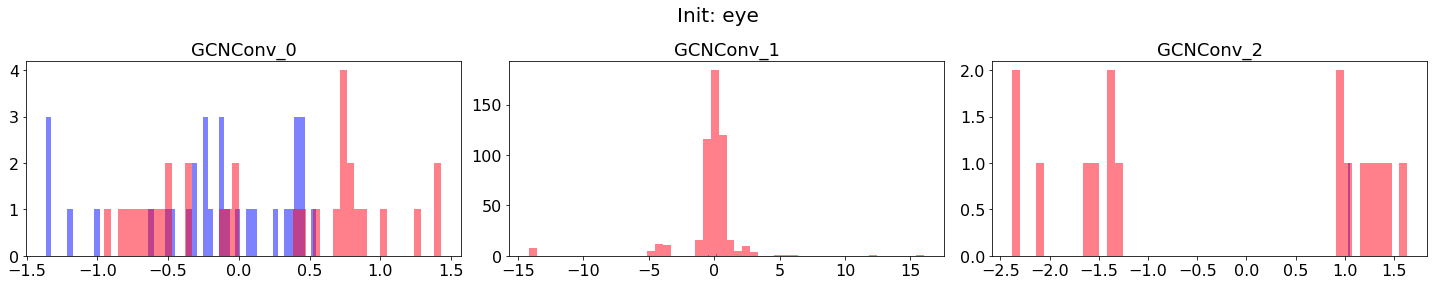

In [10]:
view_parameters(xp.trainer.model, verbose=False)

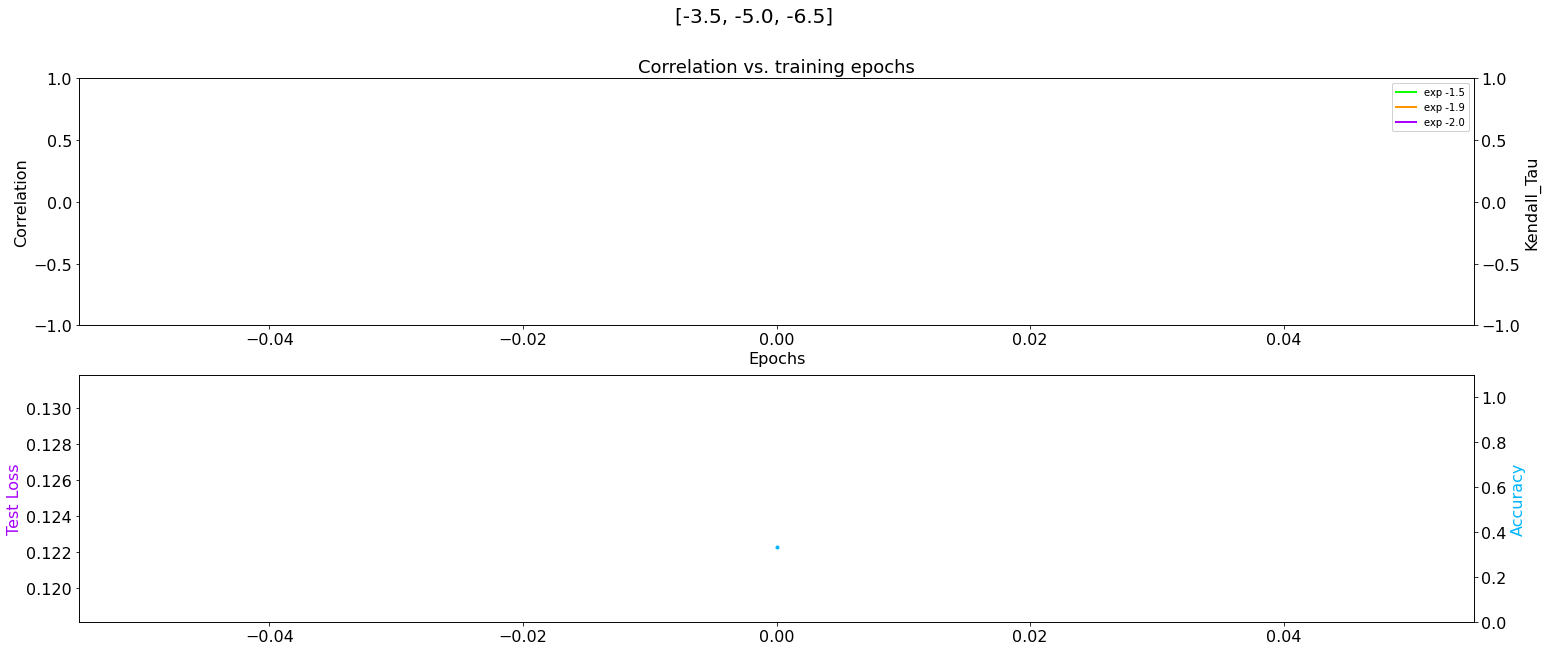

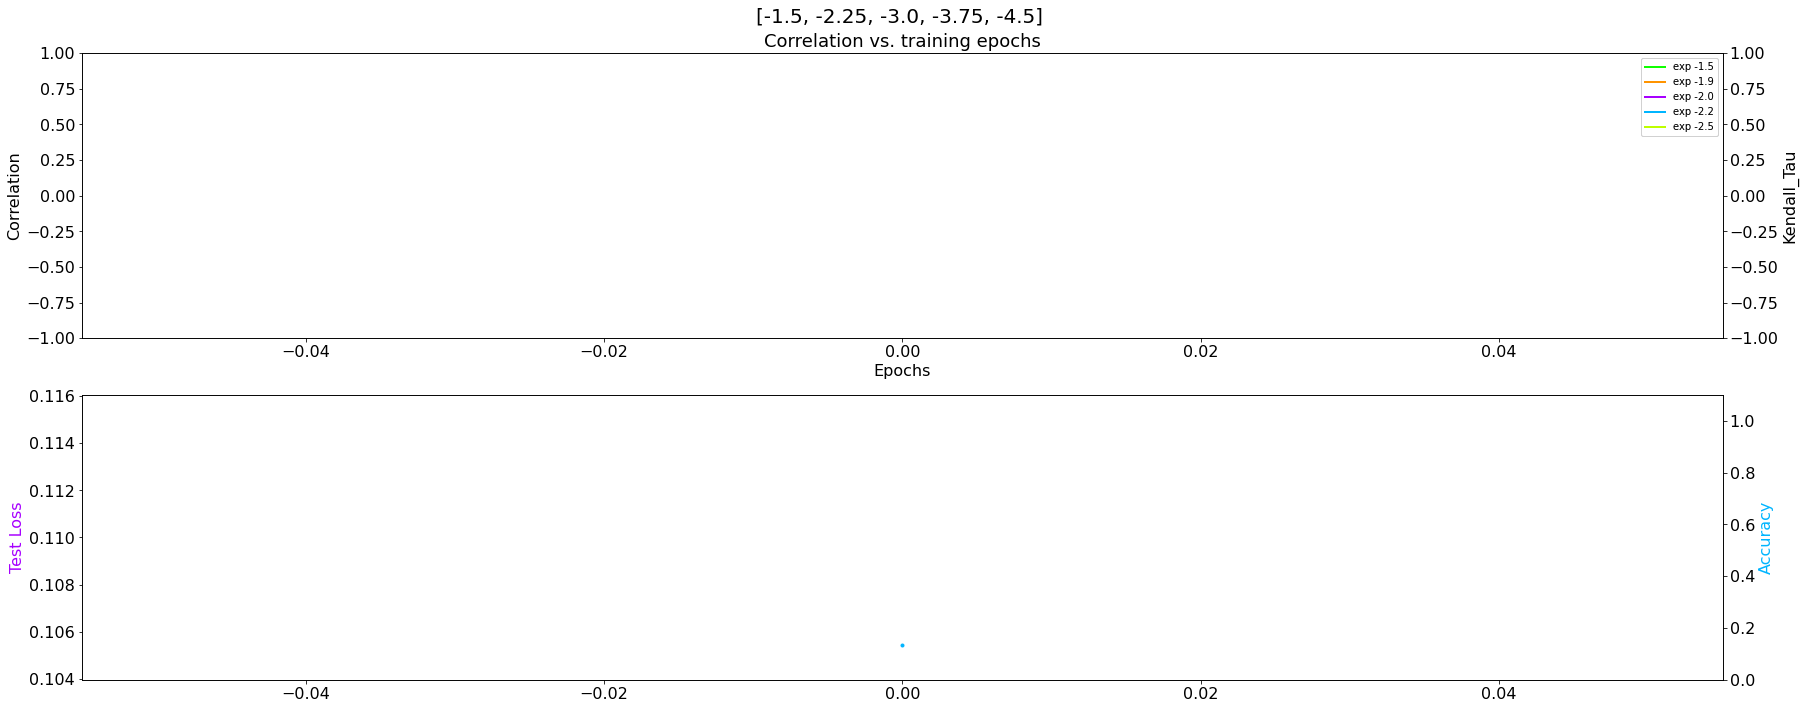

In [111]:
plot_ripetizioni_stesso_trial(xp, dot_key='graph_dataset.list_exponents', folder=None)

In [4]:
outfile = "df_configs_prova.csv"
gc.config_dataframe.to_csv(outfile)

# Embedding plot (0 epoche) con diverse init

In [5]:
diz_trials = {'graph_dataset.Num_nodes': [[35] * 6],
              'graph_dataset.list_exponents': [list(np.round(np.linspace(-3.5, -6.5, 6),2)),
                                               list(np.round(np.linspace(-1.5, -4.5, 6),2)),
                                               ],
              'model.neurons_last_linear': [[10, 10, 6]],
             'model.init_weights': ['orthogonal']*5 + ['eye']*5}

In [4]:
xp = Experiments(config_file, diz_trials, rootsave)

0 configurazioni saltate su 20, farò 20 training


/home/daniele/Documenti/Progetti/Networks/Embednet/GridConfigurations.py:70: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df_cum = df_cum.reset_index().drop(columns=['index'])


In [17]:
xp.GSdiversi_init_weights_diversi_dataset(dataset_key1='graph_dataset.list_exponents')

Run 1: 	 [-3.5, -4.1, -4.7, -5.3, -5.9, -6.5]
Generating dataset...
Dataset generated
Loading Dataset...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 744.58it/s]

Tempo impiegato: 0.11526608467102051
Run 1 	 metodo:orthogonal
calcolo i risultati di interesse


calcolo i risultati di interesse
calcolo i risultati di interesse
calcolo i risultati di interesse
calcolo i risultati di interesse
Run 6 	 metodo:eye
calcolo i risultati di interesse
calcolo i risultati di interesse
calcolo i risultati di interesse
calcolo i risultati di interesse
calcolo i risultati di interesse
Run 11: 	 [-1.5, -2.1, -2.7, -3.3, -3.9, -4.5]
Generating dataset...
Dataset generated
Loading Dataset...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 656.62it/s]

Tempo impiegato: 0.09832262992858887
Run 11 	 metodo:orthogonal
calcolo i risultati di interesse


calcolo i risultati di interesse
calcolo i risultati di interesse
calcolo i risultati di interesse
calcolo i risultati di interesse
Run 16 	 metodo:eye
calcolo i risultati di interesse
calcolo i risultati di interesse
calcolo i risultati di interesse
calcolo i risultati di interesse
calcolo i risultati di interesse


In [3]:
outfile = "output_data/df_configs_eye_orthogonal_init_weights_diverse_classi_gcn_freezed.pkl"
outfile = "output_data/df_configs_unif_kaimunif_init_weights_diverse_classi_gcn_freezed.pkl"

In [8]:
df = xp.gc.config_dataframe
df.to_pickle(outfile)

In [4]:
df = pd.read_pickle(outfile)

In [60]:
plt.rcParams['axes.labelsize'] = 10
plt.rcParams.update({'axes.titlesize': 'x-small'})
plt.rc('xtick', labelsize=10)#, direction='out', color='gray')
plt.rc('ytick', labelsize=10)#, direction='out', color='gray')

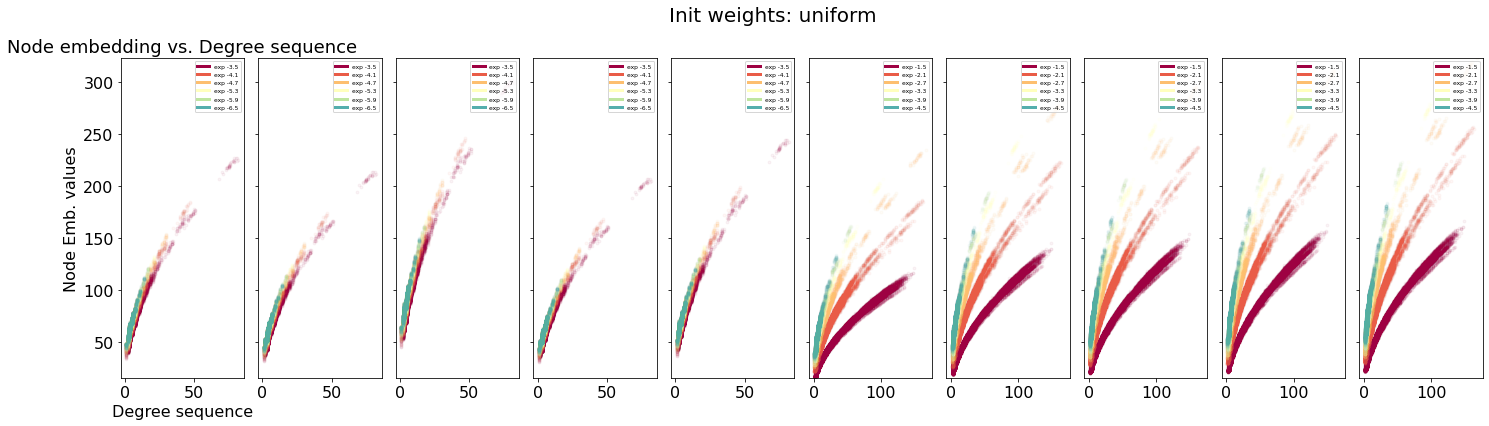

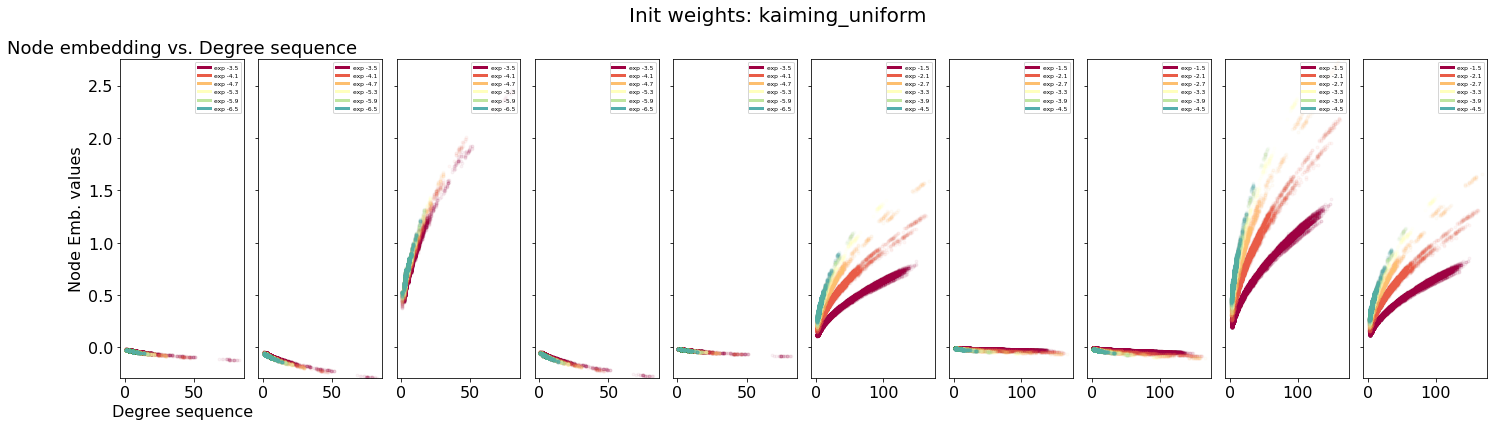

In [39]:
c = Config(config_file)
distinct = df[('model', 'init_weights')].unique()
for i, d in enumerate(distinct):
    dfi = df[df[('model', 'init_weights')] == d]
    fig, ax = plt.subplots(1, dfi.shape[0], figsize=(20, 6))
    fig.suptitle(f"Init weights: {d}")
    
    #calcolo il minimo e massimo globale di tutti gli embedding
    ser = dfi[('risultati', 'embedding_class')].apply(lambda x: np.array([emb_pergraph.node_embedding_array.flatten() for emb_class in x.emb_perclass for emb_pergraph in emb_class]).flatten())#.agg(['max', 'min'])
    global_min = ser.apply(lambda x: min(x)).min()
    global_max = ser.apply(lambda x: max(x)).max()
    
    for j, (index, row) in enumerate(dfi.iterrows()):
        emb_perclass = row[('risultati', 'embedding_class')].emb_perclass     
        fname = rootsave / Path(f"power_law_embeddings/no_training/scatter_node_emb_6class_{d}_constant_scale.png")
        if j == 0: lab=True
        else: lab = False
        scatter_node_emb(emb_perclass, sequential_colors=True, filename=fname, ax=ax[j], show=False, labels=lab, ylim=(global_min,global_max), log=False)        
    fig.tight_layout()

## applico li clustering sui vettori di embedding
 PRIMA PERÒ DEVO AUMENTARE LA DIMENSIONE DI EMBEDDING, ORA È 1, NON FACCIO MOLTO CLUSTERING CON 1

In [42]:
distinct_exp = df[('graph_dataset', 'list_exponents')].unique()
distinct_exp

array([(-3.5, -4.1, -4.7, -5.3, -5.9, -6.5),
       (-1.5, -2.1, -2.7, -3.3, -3.9, -4.5)], dtype=object)

In [51]:
df0 = df[(df[('model', 'init_weights')] == 'kaiming_uniform') & (df[('graph_dataset', 'list_exponents')] == distinct_exp[0])]
exp1 = df0[('risultati', 'embedding_class')].iloc[0]
exp1

In [63]:
X_data = np.array([[emb_pergraph.node_embedding_array.squeeze() for emb_pergraph in emb_class] for emb_class in exp1.emb_perclass ])
X_data.shape

(6, 100, 350)

In [65]:
from sklearn.cluster import DBSCAN
y_pred = DBSCAN(eps = 0.3, min_samples = 20).fit_predict(X_data)

ValueError: Found array with dim 3. DBSCAN expected <= 2.

# Studio timing e consumo memoria generazione grafi NetworkX

#### Tempo impiegato per generare 100 grafi power law con esponenti
[-1.1, -1.6, -2.1, -2.6, -3.1, -3.6, -4.1, -4.6, -5.1, -5.6, -6.1,
       -6.6]  (classi singole una alla volta)

In [ ]:

config_class = Config(config_file)
durate_exp = []
for exp in np.arange(-1.1, -7.1, -0.5):
    config_class.conf['graph_dataset']['list_exponents'] = [exp]    
    print(exp)
    durate = []
    for i in range(30):
        gg = GenerateGraph(config_class)
        starttime = time()
        gg.initialize_dataset()
        durata = round(time() - starttime, 3)
        durate.append(durata)
    durata_exp = np.mean(durate)
    durate_exp.append(durata_exp)
    #print(f"Exp: {exp}\tDurata: {round(durata,2)}")

In [15]:
print(np.round(np.array(durate_exp),3))  # tempo espresso in secondi

[5.563 2.531 1.549 1.11  0.928 1.017 0.849 0.882 0.872 0.91  1.06  0.923]


#### Ora genero più grafi, sempre 100 per classe, n classi

In [18]:
config_class = Config(config_file)
durate_exp = []
for n in range(2,5): #num classi
#for exp in np.arange(-1.1, -7.1, -0.5):
    list_exp = np.linspace(-1.5, -4.5, n)
    config_class.conf['graph_dataset']['list_exponents'] = list_exp 
    config_class.conf['graph_dataset']['Num_nodes'] = [500]*n  # per validare il config
    config_class.conf['model']['neurons_last_linear'] = [10, 10, n] # per validare il config
    print(list_exp)
    durate = []
    for i in range(3):
        gg = GenerateGraph(config_class)
        starttime = time()
        gg.initialize_dataset()
        durata = round(time() - starttime, 3)
        durate.append(durata)
    durata_exp = np.mean(durate)
    durate_exp.append(durata_exp)

[-1.5 -4.5]
Generating dataset...
Dataset generated
Generating dataset...
Dataset generated
Generating dataset...
Dataset generated
[-1.5 -3.  -4.5]
Generating dataset...
Dataset generated
Generating dataset...
Dataset generated
Generating dataset...
Dataset generated
[-1.5 -2.5 -3.5 -4.5]
Generating dataset...
Dataset generated
Generating dataset...
Dataset generated
Generating dataset...
Dataset generated


In [20]:
print(np.round(np.array(durate_exp)/np.array([2,3,4]),3))

[15.395 23.486 28.278]


#### Sembra che il tempo dipenda dal numero delle classi, non dall'esponente della powerlaw
#### ora studio l'uso della memoria

In [3]:
# voglio tracciare il consumo di memoria per sapere il numero massimo di classi per non far scoppiare la RAM


class MemoryMonitor:
    def __init__(self):
        self.keep_measuring = True
        
    def Gbyte(self, memoria):
        return round(memoria/1024/1024/1024, 3)

    def measure_usage(self):
        max_usage = 0
        while self.keep_measuring:
            print(max_usage)
            max_usage = max(
                max_usage,
                resource.getrusage(resource.RUSAGE_SELF).ru_maxrss
            )
            sleep(0.1)

        return self.Gbyte(max_usage)
    
    def process_memory(self):
        max_usage = 0
        while self.keep_measuring:
            print(max_usage)
            process = psutil.Process(os.getpid())
            mem_info = process.memory_info()
            mem_usage = mem_info.rss
            max_usage = max( max_usage, mem_usage)
            sleep(1.0)
        return self.Gbyte(max_usage)
    
    def simple_psutil(self):
        max_usage = 0
        while self.keep_measuring:
            #print(max_usage)
            mem_usage = psutil.virtual_memory().used  #.percent
            max_usage = max( max_usage, mem_usage)
            sleep(1.0)
        return self.Gbyte(max_usage)

In [4]:
def gen_graphs(config_class):
    gg = GenerateGraph(config_class)
    gg.initialize_dataset()

def monitor_memory():
    config_class = Config(config_file)
    durate_exp = []
    for n in range(2,3): #num classi
    #for exp in np.arange(-1.1, -7.1, -0.5):
        #list_exp = np.linspace(-1.5, -4.5, n)
        list_exp = [-2.0] * n
        config_class.conf['graph_dataset']['list_exponents'] = list_exp 
        config_class.conf['graph_dataset']['Num_nodes'] = [500]*n  # per validare il config
        config_class.conf['model']['neurons_last_linear'] = [10, 10, n] # per validare il config
        print(list_exp)
        durate = []
        for i in range(3):
            gg = GenerateGraph(config_class)
            starttime = time()
            gg.initialize_dataset()
            durata = round(time() - starttime, 3)
            durate.append(durata)
        durata_exp = np.mean(durate)
        durate_exp.append(durata_exp)
    return durate_exp

with ThreadPoolExecutor() as executor:
    monitor = MemoryMonitor()
    #mem_thread = executor.submit(monitor.measure_usage) 
    #mem_thread = executor.submit(monitor.process_memory)
    mem_thread = executor.submit(monitor.simple_psutil)
    try:
        fn_thread = executor.submit(monitor_memory)
        result = fn_thread.result()
    finally:
        monitor.keep_measuring = False
        max_usage = mem_thread.result()
        
    print(f"Peak memory usage: {max_usage}")

In [5]:
def gen_graphs(config_class):
    gg = GenerateGraph(config_class)
    gg.initialize_dataset()

def studio_memoria(num_nodi=50, list_exp=[-2.0], ripetizioni=30):
    config_class = Config(config_file)
    n = len(list_exp)
    config_class.conf['graph_dataset']['list_exponents'] = list_exp 
    config_class.conf['graph_dataset']['Num_nodes'] = [num_nodi]*n  # per validare il config
    config_class.conf['model']['neurons_last_linear'] = [10, 10, n] # per validare il config
    print(list_exp)
    memorie = []
    for i in range(ripetizioni):
        with ThreadPoolExecutor() as executor:
            monitor = MemoryMonitor()
            mem_thread = executor.submit(monitor.simple_psutil)
            try:
                fn_thread = executor.submit(gen_graphs, config_class)
                result = fn_thread.result()
            finally:
                monitor.keep_measuring = False
                max_usage = mem_thread.result()
            memorie.append(max_usage)
            print(f"max_usage run {i}: {max_usage}")
    return memorie

#### con 500 nodi, esponenti -2.0, numero di classi: [2,3,4,5,6]

In [99]:
memorie_class  # gigabyte di RAM

[19.088350677490233,
 25.21703160603841,
 27.7756228129069,
 29.82162030537923,
 30.34625155131022]

In [ ]:
memorie_class = studio_memoria(num_nodi=50, exp=-2.0, ripetizioni=30)

#### 50 nodi, exp -2.0, num classi: [2, 3, 4, 5, 6, 7, 8, 9]

In [9]:
memorie_class

[7.813662592569987,
 8.909784317016602,
 10.321888478597005,
 11.312373606363932,
 12.317812856038412,
 12.96157709757487,
 13.160469309488933,
 13.363260142008464]

In [14]:
np.linspace(-3.5, -6.5, 6)

array([-3.5, -4.1, -4.7, -5.3, -5.9, -6.5])

In [ ]:
memoria = studio_memoria(num_nodi=250, list_exp=[-6.5]*3, ripetizioni=30)

In [21]:
# classi: [-6.5, -6.5, -6.5], nodi 250, 30 ripetizioni
np.mean(memoria)

13.290299999999998

In [ ]:
memoria = studio_memoria(num_nodi=250, list_exp=[-6.5]*6, ripetizioni=30)

In [24]:
np.mean(memoria)

15.579633333333334

In [ ]:
memoria = studio_memoria(num_nodi=250, list_exp=[-1.5]*6, ripetizioni=20)

In [27]:
np.mean(memoria)

25.9093

In [ ]:
memoria = studio_memoria(num_nodi=250, list_exp=np.linspace(-3.5, -6.5, 6), ripetizioni=9)

In [10]:
np.mean(memoria)

15.502999999999998

In [ ]:
memoria = studio_memoria(num_nodi=250, list_exp=np.linspace(-1.5, -4.5, 6), ripetizioni=9)

In [9]:
np.mean(memoria)

18.61711111111111

In [ ]:
list(np.round(np.linspace(-3.5, -6.5, 6),2))

In [10]:
memoria = studio_memoria(num_nodi=350, list_exp=list(np.round(np.linspace(-3.5, -6.5, 6),2)), ripetizioni=1)

[-3.5, -4.1, -4.7, -5.3, -5.9, -6.5]
Generating dataset...
Dataset generated
max_usage run 0: 18.043


In [11]:
np.mean(memoria)

18.043

tracemalloc.start()
monitor_memory()
current, peak = tracemalloc.get_traced_memory()
print(f"Current memory usage is {current / 10**6}MB; Peak was {peak / 10**6}MB")
tracemalloc.stop()